# Synthetic Seismic Models

In [1]:
import bruges as bg
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

เราสามารถ import ภาพของ geological model หรือสร้างขึ้นมาเองโดยใช้ `bruges` module

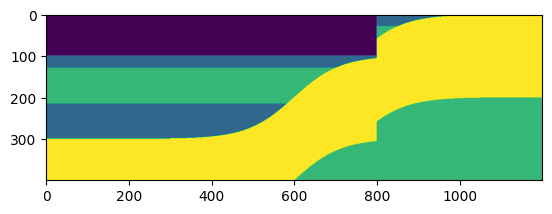

In [2]:
# Build a synthetic geological model
init_model, *_ = bg.models.wedge(
    depth=(100, 200, 200),                     # y-axis
    width=(300, 600, 300),                     # x-axis
    strat=(0, (1, 2, 2, 2, 1, 1, 1), (3, 2)),  # geological units
    thickness=(1, 0),                          # slope
    mode='sigmoid',                            # try: linear, sigmoid, power, root
    conformance='top'                          # try: non, top, base, 
)

# Include a fault in our model
model = np.zeros(
    (np.shape(init_model)[0] - 100, np.shape(init_model)[1])
).astype(int)      
model[:,:800] = init_model[:-100, :800]
model[:,-400:] = init_model[100:, -550: -150]

plt.imshow(model);

In [3]:
# Assign rock properties for each geological unit (0, 1, 2, 3)
densities = np.array([1620, 1840, 2900, 2300])  # kg/m^3
velocities = np.array([2000, 2600, 5000, 3920])  # m/s
impedances = densities * velocities
impedances

array([ 3240000,  4784000, 14500000,  9016000])

In [4]:
# Assign impedance to each pixel in the model
impedances_model = impedances[model]
impedances_model.shape

(400, 1200)

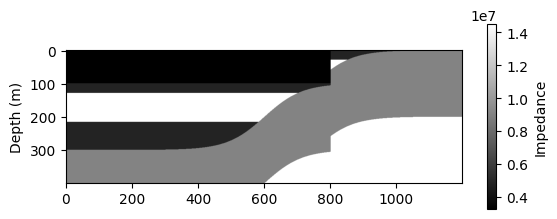

In [5]:
plt.imshow(impedances_model, cmap='gray', aspect=1)
plt.ylabel('Depth (m)')
plt.colorbar(label='Impedance', shrink=0.5);

In [6]:
# Compute the reflection coefficients (rc)
rc_model = (impedances_model[1:] - impedances_model[:-1]) / \
           (impedances_model[1:] + impedances_model[:-1])

In [7]:
# Choose a profile to plot logs
profile = np.shape(impedances_model)[1] - 1000

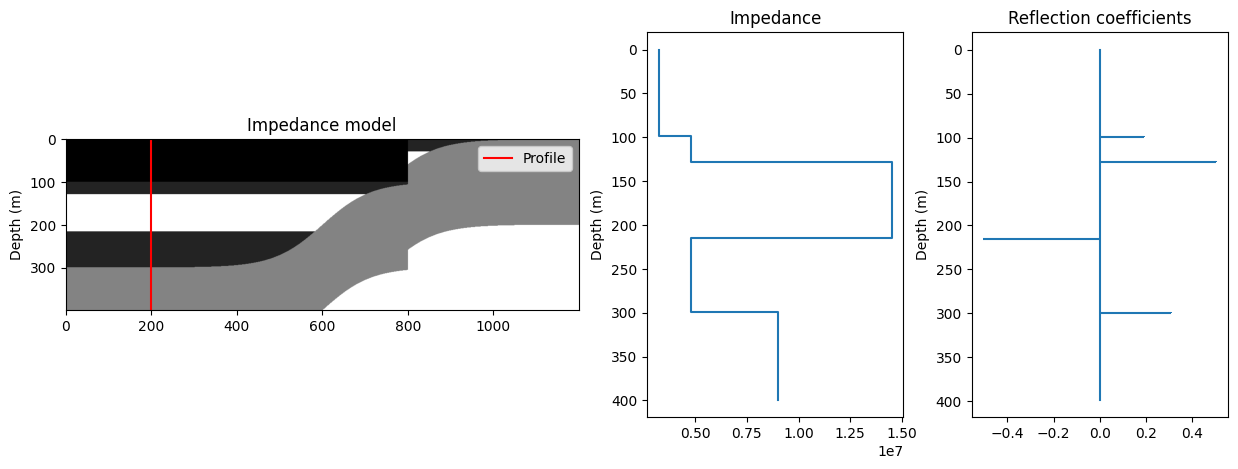

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': (4, 2, 2)})

axs[0].imshow(impedances_model, cmap='gray')
axs[0].axvline(profile, c='r', label='Profile')
axs[0].set(title='Impedance model', ylabel='Depth (m)')
axs[0].legend()

axs[1].step(impedances_model[:, profile], np.arange(len(impedances_model)), where='post')
axs[1].set(title='Impedance', ylabel='Depth (m)')
axs[1].invert_yaxis()

axs[2].stem(
    rc_model[:, profile],
    markerfmt=',',
    basefmt='C0-',
    orientation='horizontal'
)
axs[2].set(title='Reflection coefficients', ylabel='Depth (m)')
axs[2].invert_yaxis();

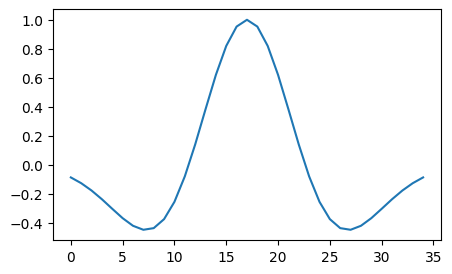

In [9]:
# Create a wavelet - ricker (you can try others, e.g., ormsby, klauder)
fig, ax = plt.subplots(figsize=(5, 3))
ricker, _ = bg.filters.ricker(duration=0.07, dt=0.002, f=20)
ax.plot(ricker);

In [10]:
# Convolve the reflectivity function with the wavelet to produce synthetic seismic traces
syn_trace = np.apply_along_axis(np.convolve, arr=rc_model, axis=0, v=ricker, mode='same')

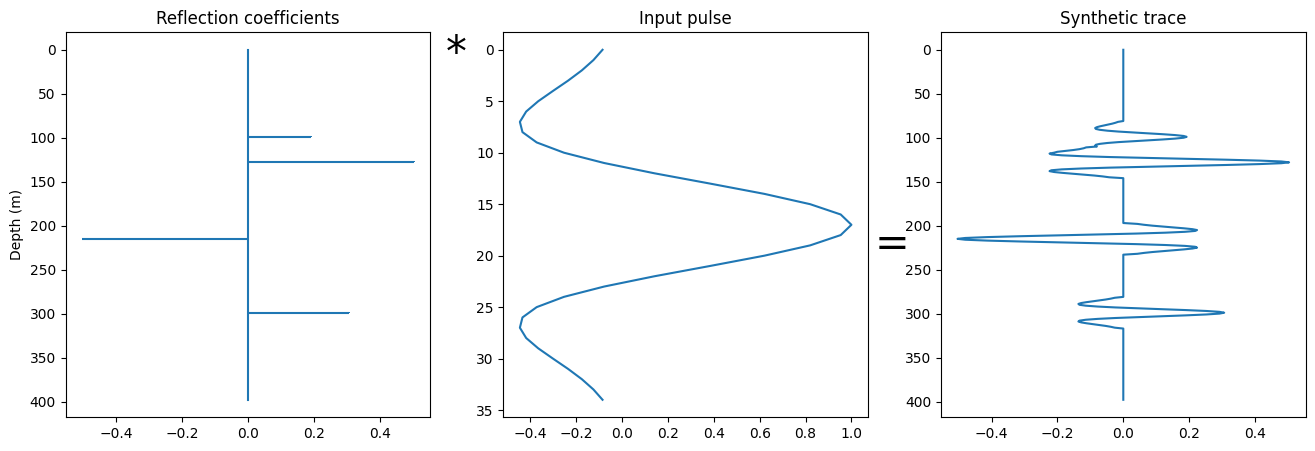

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].stem(
    rc_model[:, profile],
    markerfmt=',',
    basefmt='C0-',
    orientation='horizontal'
)
axs[0].set(title='Reflection coefficients', ylabel='Depth (m)')
axs[0].text(.6, 18, '*', size=30)
axs[0].invert_yaxis()

axs[1].plot(ricker, np.arange(len(ricker)))
axs[1].set(title='Input pulse')
axs[1].text(1.1, 20, '=', size=30)
axs[1].invert_yaxis()

axs[2].plot(syn_trace[:, profile], np.arange(len(syn_trace)))
axs[2].set(title='Synthetic trace')
axs[2].invert_yaxis()

เนื่องจากเราไม่สามารถสร้าง spike ได้ ต้องใช้ wavelet with a finite width เมื่อ convolute กับ reflectivity function จะได้ seismic image ที่เบลอ ถ้าใช้ wavelet ที่มีความถี่สูง จะได้ภาพชัดขึ้น แต่คลื่นความถี่สูงจะสูญเสียพลังงานได้ง่ายขณะเดินทางผ่านตัวกลาง ทำให้ไม่สามารถเดินทางลงไปได้ลึก

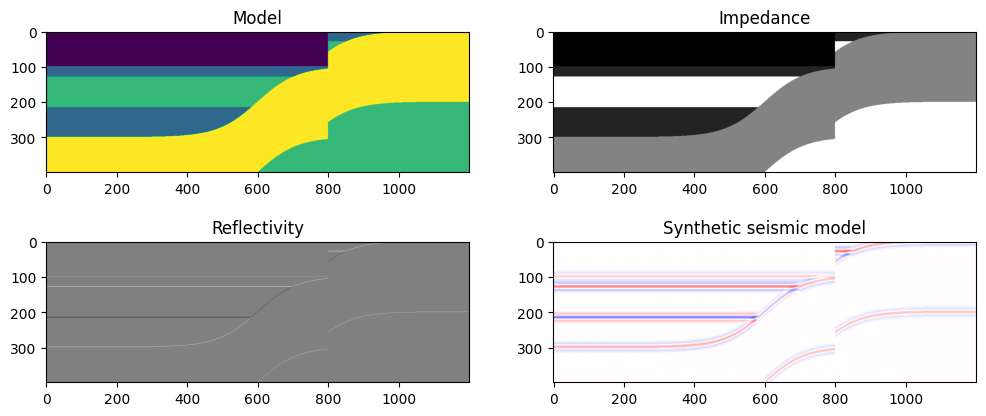

In [12]:
# Create a 2D synthetic seismic model
fig, axs = plt.subplots(2, 2, figsize=(12, 5))
axs[0, 0].imshow(model)
axs[0, 0].set_title('Model')
axs[0, 1].imshow(impedances_model, cmap='gray')
axs[0, 1].set_title('Impedance')
axs[1, 0].imshow(rc_model, cmap='gray')
axs[1, 0].set_title('Reflectivity')
axs[1, 1].imshow(syn_trace, cmap='seismic', vmin=-2, vmax=2)
axs[1, 1].set_title('Synthetic seismic model');